In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as  sns
import re
%matplotlib inline
plt.style.use('ggplot')
from sklearn.preprocessing import LabelEncoder

survey = pd.read_csv(r"C:\Users\haosu\Desktop\survey.csv")
survey.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [18]:
survey = survey.drop(["Timestamp", "comments", "state"], axis =1)

In [20]:
import sklearn.preprocessing

In [29]:
from sklearn.impute import SimpleImputer 
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

In [24]:
encoders = dict()
enc_no_employees = {'1-5':0, '6-25':1, '26-100':2, '100-500':3, '500-1000':4, 'More than 1000':5}
surv_no_employees = survey.no_employees.apply(lambda row: enc_no_employees[row])

enc_leave = {'Somewhat easy':3, "Don't know":2, 'Somewhat difficult':1,
       'Very difficult':0, 'Very easy':4}
surv_leave = survey.leave.apply(lambda row: enc_leave[row])

for x in range(2,23):
    encoders['le'+str(x-2)]= LabelEncoder()
    survey.iloc[:,x] = encoders['le'+str(x-2)].fit_transform(survey.iloc[:,x].astype(str))
survey['leave'] = surv_leave
survey['no_employees'] = surv_no_employees
survey.head()

,Age,Gender,Country,self_employed,family_history,treatment,no_employees,remote_work,tech_company,benefits,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,Female,45,2,0,1,1,0,1,2,...,2,3,1,1,1,2,1,0,2,0
1,44,M,45,2,0,0,5,0,0,0,...,0,2,0,1,0,0,1,1,0,0
2,32,Male,7,2,0,0,1,0,1,1,...,0,1,1,1,2,2,2,2,1,0
3,31,Male,44,2,1,1,2,0,1,1,...,1,1,2,2,1,0,0,0,1,1
4,31,Male,45,2,0,0,3,1,1,2,...,0,2,1,1,1,2,2,2,0,0


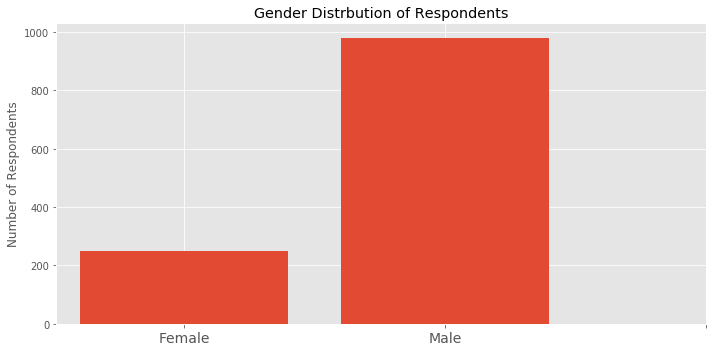

In [32]:
def encode(text):
    text = text.lower()
    if text in ['male', 'm', 'mail', 'make','man', 'malr','mal', 'maile',]:
        text = 1
        return text
    elif text in ['f', 'female', 'femake', 'woman']:
        text = 0
        return text
    elif 'female' in text:
        text = 0
        return text
    else:
        text = 2
        return text

survey.Gender = survey.Gender.apply(encode)

survey = survey[survey.Gender !=2]
plt.figure(figsize =(10,5))
plt.bar(survey.Gender.value_counts().index, survey.Gender.value_counts())
xticks = plt.gca()
plt.xticks([0,1,2], ['Female','Male'])
plt.gca().set_xticklabels(['Female', 'Male'], fontsize = 14)
plt.title('Gender Distrbution of Respondents')
plt.ylabel('Number of Respondents')
plt.tight_layout()
plt.show()

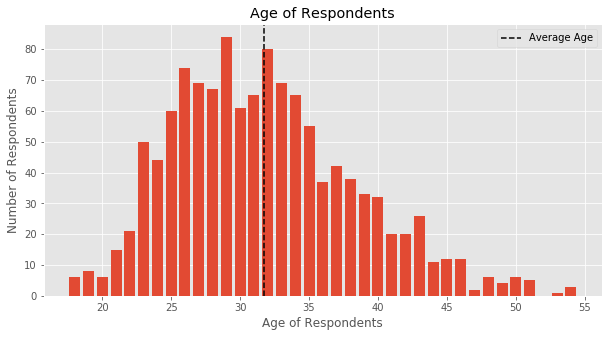

In [33]:
survey = survey[survey.Age>15]
survey = survey[survey.Age<55]

plt.figure(figsize =(10,5))
survey.Age.value_counts()
plt.bar(survey.Age.value_counts().index, survey.Age.value_counts())
plt.title('Age of Respondents')
plt.ylabel('Number of Respondents')
plt.xlabel('Age of Respondents')
av_age = np.mean(survey.Age)
plt.axvline(av_age,
           color = 'black',
           linestyle = '--'
           , label='Average Age')
plt.legend()
plt.show()

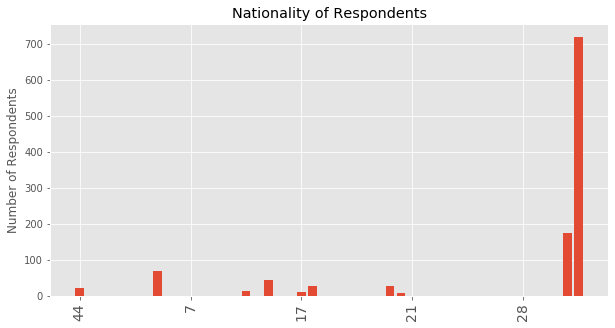

In [34]:
plt.figure(figsize =(10,5))
plt.bar(survey.Country.value_counts().index[0:10], survey.Country.value_counts()[0:10])
plt.title('Nationality of Respondents')
plt.ylabel('Number of Respondents')
plt.gca().set_xticklabels(survey.Country.value_counts().index[0:10],rotation =90, fontsize = 14)
plt.show()

In [35]:
survey = survey.drop(["Age", "Gender",], axis = 1)


In [36]:
survey = survey.drop(["Country"], axis =1)


In [37]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN #For clustering
from matplotlib import cm
from sklearn.metrics import silhouette_samples, silhouette_score


def inertia_plot( clust, X, start = 2, stop = 10):
    #A simple inertia plotter to decide K in KMeans
    inertia = []
    for x in range(start,stop):
        km = clust(n_clusters = x)
        labels = km.fit_predict(X)
        inertia.append(km.inertia_)
    plt.figure(figsize = (10,6))
    plt.plot(range(start,stop), inertia, marker = 'o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Inertia Decrease with K')
    plt.xticks(list(range(start, stop)))
    plt.show()

def silh_samp_cluster(clust,  X, start=2, stop=5, metric = 'euclidean'):
    # Taken from sebastian Raschkas book Python Machine Learning second edition
    for x in range(start, stop):
        km = clust(n_clusters = x)
        y_km = km.fit_predict(X)
        cluster_labels = np.unique(y_km)
        n_clusters = cluster_labels.shape[0]
        silhouette_vals = silhouette_samples(X, y_km, metric = metric)
        y_ax_lower, y_ax_upper =0,0
        yticks = []
        for i, c in enumerate(cluster_labels):
            c_silhouette_vals = silhouette_vals[y_km == c]
            c_silhouette_vals.sort()
            y_ax_upper += len(c_silhouette_vals)
            color = cm.jet(float(i)/n_clusters)
            plt.barh(range(y_ax_lower, y_ax_upper),
                    c_silhouette_vals,
                    height=1.0,
                    edgecolor='none',
                    color = color)
            yticks.append((y_ax_lower + y_ax_upper)/2.)
            y_ax_lower+= len(c_silhouette_vals)

        silhouette_avg = np.mean(silhouette_vals)
        plt.axvline(silhouette_avg,
                   color = 'red',
                   linestyle = "--")
        plt.yticks(yticks, cluster_labels+1)
        plt.ylabel("cluster")
        plt.xlabel('Silhouette Coefficient')
        plt.title('Silhouette for ' + str(x) + " Clusters")
        plt.show()

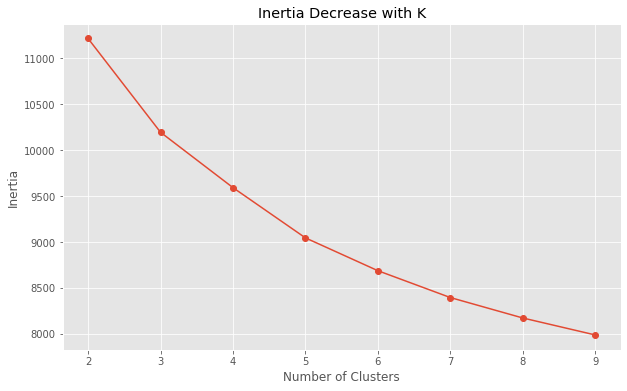

In [38]:
inertia_plot(KMeans, survey)


In [39]:
for x in range(2,8):
    ag = KMeans(n_clusters = x, )
    label = ag.fit_predict(survey)
    print('Silhouette-Score for', x,  'Clusters: ', silhouette_score(survey, label))


Silhouette-Score for 2 Clusters:  0.19099834443399927
Silhouette-Score for 3 Clusters:  0.14163211779593562
Silhouette-Score for 4 Clusters:  0.12150900305799774
Silhouette-Score for 5 Clusters:  0.11612112338179763
Silhouette-Score for 6 Clusters:  0.11741991223741477
Silhouette-Score for 7 Clusters:  0.10698702835281597


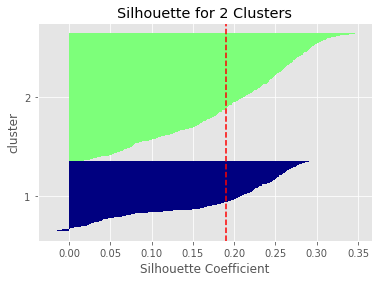

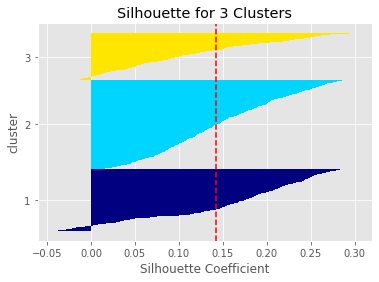

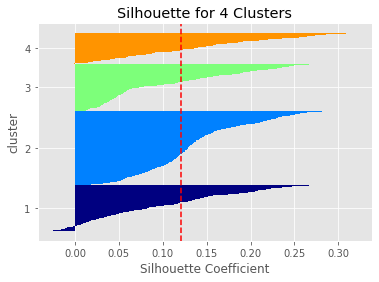

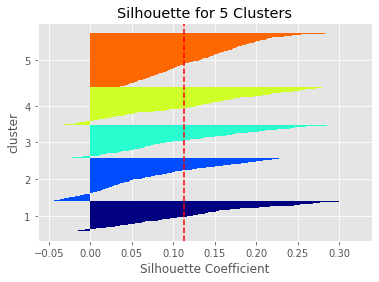

In [40]:
silh_samp_cluster(KMeans, survey, stop =6)


In [41]:
for x in range(2,8):
    ag = AgglomerativeClustering(n_clusters = x, )
    label = ag.fit_predict(survey)
    print('Silhouette-Score for', x,  'Clusters: ', silhouette_score(survey, label))

Silhouette-Score for 2 Clusters:  0.1965709194292001
Silhouette-Score for 3 Clusters:  0.11195933280363203
Silhouette-Score for 4 Clusters:  0.09979111096256836
Silhouette-Score for 5 Clusters:  0.08727975194310092
Silhouette-Score for 6 Clusters:  0.08760098945117002
Silhouette-Score for 7 Clusters:  0.08980342970987766


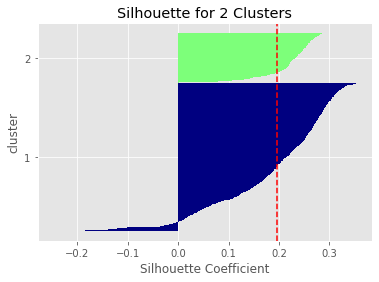

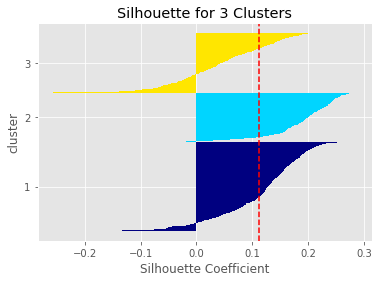

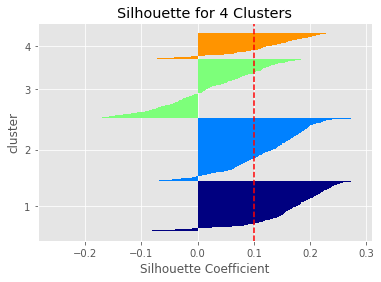

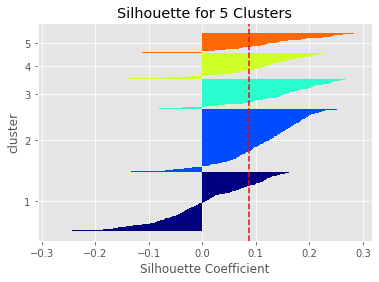

In [42]:
silh_samp_cluster(AgglomerativeClustering, survey, stop =6)


In [43]:
from sklearn.decomposition import PCA
for y in range(2,6):
    print("PCA with # of components: ", y)
    pca = PCA(n_components =y)
    survey_p = pca.fit_transform(survey)
    for x in range(2, 9):
        ag = KMeans(n_clusters = x, )
        label = ag.fit_predict(survey_p)
        print('Silhouette-Score for', x,  'Clusters: ', silhouette_score(survey_p, label) , '       Inertia: ',ag.inertia_)
    print()


PCA with # of components:  2
Silhouette-Score for 2 Clusters:  0.4347899315650252        Inertia:  3061.1422456449004
Silhouette-Score for 3 Clusters:  0.4084535451237986        Inertia:  2057.4545879717652
Silhouette-Score for 4 Clusters:  0.38788215330569686        Inertia:  1542.800052037101
Silhouette-Score for 5 Clusters:  0.3857297200142991        Inertia:  1177.7192109054702
Silhouette-Score for 6 Clusters:  0.39159720317394725        Inertia:  954.0426943809707
Silhouette-Score for 7 Clusters:  0.3832979525625162        Inertia:  824.7009603034519
Silhouette-Score for 8 Clusters:  0.37701515431778226        Inertia:  722.6257563095596

PCA with # of components:  3
Silhouette-Score for 2 Clusters:  0.34806874967815227        Inertia:  4575.184941308128
Silhouette-Score for 3 Clusters:  0.30573350698978113        Inertia:  3570.7636228387273
Silhouette-Score for 4 Clusters:  0.2872580150508001        Inertia:  2986.6880701782707
Silhouette-Score for 5 Clusters:  0.289500132666214

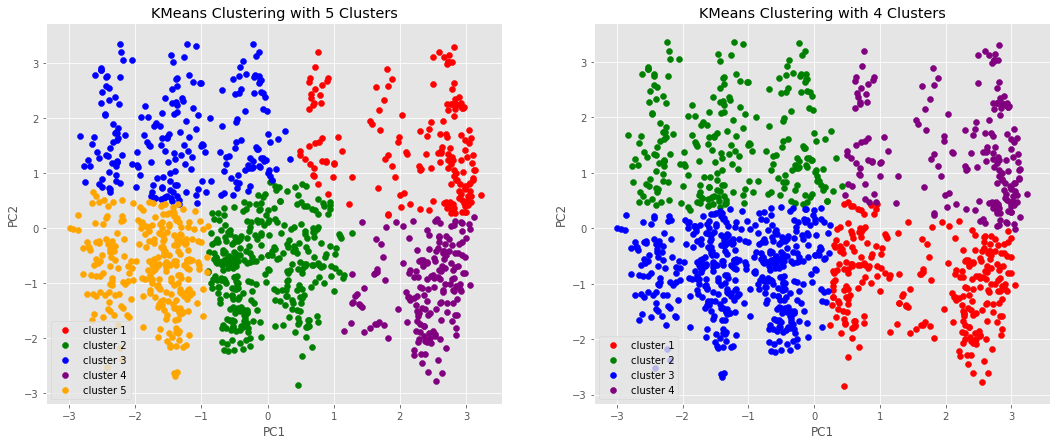

In [44]:
survey_p = pd.DataFrame(PCA(n_components = 2).fit_transform(survey))
preds = pd.Series(KMeans(n_clusters = 5,).fit_predict(survey_p))
survey_p = pd.concat([survey_p, preds], axis =1)
survey_p.columns = [0,1,'target']

fig = plt.figure(figsize = (18, 7))
colors = ['red', 'green', 'blue', 'purple', 'orange']
plt.subplot(121)
plt.scatter(survey_p[survey_p['target']==0].iloc[:,0], survey_p[survey_p.target==0].iloc[:,1], c = colors[0], label = 'cluster 1')
plt.scatter(survey_p[survey_p['target']==1].iloc[:,0], survey_p[survey_p.target==1].iloc[:,1], c = colors[1], label = 'cluster 2')
plt.scatter(survey_p[survey_p['target']==2].iloc[:,0], survey_p[survey_p.target==2].iloc[:,1], c = colors[2], label = 'cluster 3')
plt.scatter(survey_p[survey_p['target']==3].iloc[:,0], survey_p[survey_p.target==3].iloc[:,1], c = colors[3], label = 'cluster 4')
plt.scatter(survey_p[survey_p['target']==4].iloc[:,0], survey_p[survey_p.target==4].iloc[:,1], c = colors[4], label = 'cluster 5')
plt.legend()
plt.title('KMeans Clustering with 5 Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')

survey_p = pd.DataFrame(PCA(n_components = 2).fit_transform(survey))
preds = pd.Series(KMeans(n_clusters = 4,).fit_predict(survey_p))
survey_p = pd.concat([survey_p, preds], axis =1)
survey_p.columns = [0,1,'target']

plt.subplot(122)
plt.scatter(survey_p[survey_p['target']==0].iloc[:,0], survey_p[survey_p.target==0].iloc[:,1], c = colors[0], label = 'cluster 1')
plt.scatter(survey_p[survey_p['target']==1].iloc[:,0], survey_p[survey_p.target==1].iloc[:,1], c = colors[1], label = 'cluster 2')
plt.scatter(survey_p[survey_p['target']==2].iloc[:,0], survey_p[survey_p.target==2].iloc[:,1], c = colors[2], label = 'cluster 3')
plt.scatter(survey_p[survey_p['target']==3].iloc[:,0], survey_p[survey_p.target==3].iloc[:,1], c = colors[3], label = 'cluster 4')
plt.legend()
plt.title('KMeans Clustering with 4 Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

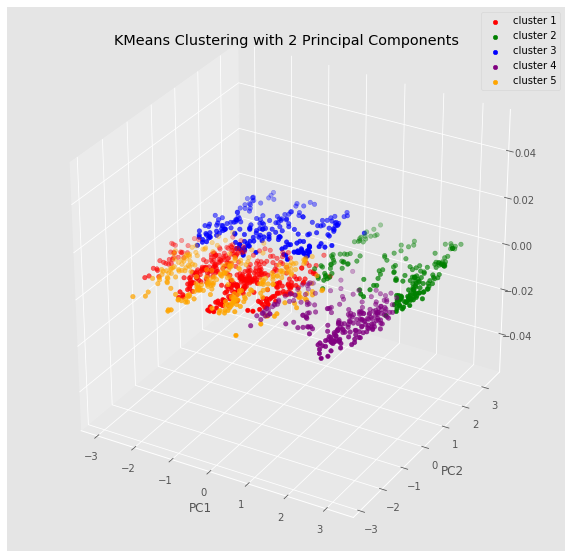

In [45]:
from mpl_toolkits.mplot3d import Axes3D

survey_p3 = pd.DataFrame(PCA(n_components = 3).fit_transform(survey))
preds = pd.Series(KMeans(n_clusters = 5,).fit_predict(survey_p3))
survey_p3 = pd.concat([survey_p3, preds], axis =1)
survey_p3.columns = [0,1,2, 'target']

fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection='3d')
colors = ['red', 'green', 'blue', 'purple', 'orange']
ax.scatter(survey_p3[survey_p3['target']==0].iloc[:,0], survey_p3[survey_p3.target==0].iloc[:,1], c = colors[0], label = 'cluster 1')
ax.scatter(survey_p3[survey_p3['target']==1].iloc[:,0], survey_p3[survey_p3.target==1].iloc[:,1], c = colors[1], label = 'cluster 2')
ax.scatter(survey_p3[survey_p3['target']==2].iloc[:,0], survey_p3[survey_p3.target==2].iloc[:,1], c = colors[2], label = 'cluster 3')
ax.scatter(survey_p3[survey_p3['target']==3].iloc[:,0], survey_p3[survey_p3.target==3].iloc[:,1], c = colors[3], label = 'cluster 4')
ax.scatter(survey_p3[survey_p3['target']==4].iloc[:,0], survey_p3[survey_p3.target==4].iloc[:,1], c = colors[4], label = 'cluster 5')
plt.legend()
plt.title('KMeans Clustering with 2 Principal Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [46]:
for y in range(2,6):
    print("PCA with # of components: ", y)
    pca = PCA(n_components =y)
    survey_p = pca.fit_transform(survey)
    for x in range(2, 9):
        ag = AgglomerativeClustering(n_clusters = x, )
        label = ag.fit_predict(survey_p)
        print('Silhouette-Score for', x,  'Clusters: ', silhouette_score(survey_p, label))
    print()

PCA with # of components:  2
Silhouette-Score for 2 Clusters:  0.44520881715505534
Silhouette-Score for 3 Clusters:  0.3982299191186384
Silhouette-Score for 4 Clusters:  0.3276183022144291
Silhouette-Score for 5 Clusters:  0.32329013532714285
Silhouette-Score for 6 Clusters:  0.3316403407195026
Silhouette-Score for 7 Clusters:  0.3263494817838796
Silhouette-Score for 8 Clusters:  0.32740809639894186

PCA with # of components:  3
Silhouette-Score for 2 Clusters:  0.36117292431014203
Silhouette-Score for 3 Clusters:  0.25626952701416167
Silhouette-Score for 4 Clusters:  0.24129227970157377
Silhouette-Score for 5 Clusters:  0.22281849577723523
Silhouette-Score for 6 Clusters:  0.21074726046521516
Silhouette-Score for 7 Clusters:  0.21810898307468224
Silhouette-Score for 8 Clusters:  0.23070224148049093

PCA with # of components:  4
Silhouette-Score for 2 Clusters:  0.32590300624522983
Silhouette-Score for 3 Clusters:  0.23294182437158162
Silhouette-Score for 4 Clusters:  0.229665657438221

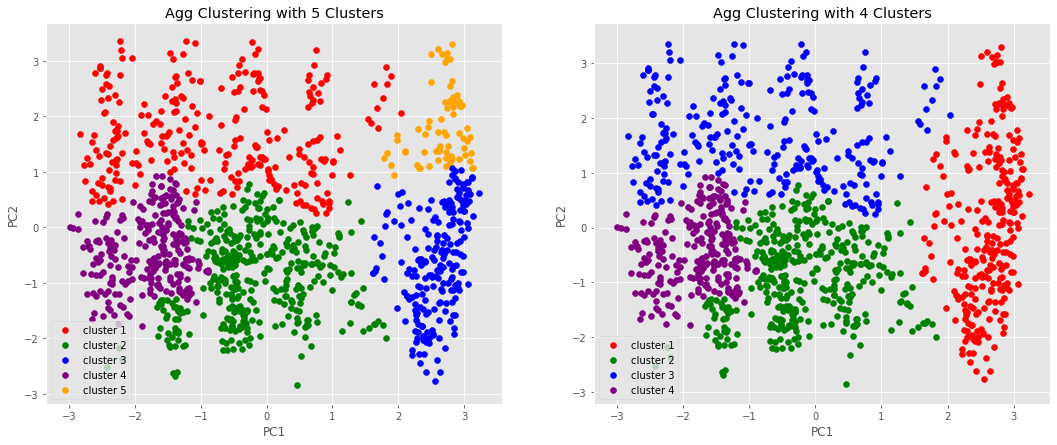

In [47]:
survey_p = pd.DataFrame(PCA(n_components = 2).fit_transform(survey))
preds = pd.Series(AgglomerativeClustering(n_clusters = 5,).fit_predict(survey_p))
survey_p = pd.concat([survey_p, preds], axis =1)
survey_p.columns = [0,1,'target']

fig = plt.figure(figsize = (18, 7))
colors = ['red', 'green', 'blue', 'purple', 'orange']
plt.subplot(121)
plt.scatter(survey_p[survey_p['target']==0].iloc[:,0], survey_p[survey_p.target==0].iloc[:,1], c = colors[0], label = 'cluster 1')
plt.scatter(survey_p[survey_p['target']==1].iloc[:,0], survey_p[survey_p.target==1].iloc[:,1], c = colors[1], label = 'cluster 2')
plt.scatter(survey_p[survey_p['target']==2].iloc[:,0], survey_p[survey_p.target==2].iloc[:,1], c = colors[2], label = 'cluster 3')
plt.scatter(survey_p[survey_p['target']==3].iloc[:,0], survey_p[survey_p.target==3].iloc[:,1], c = colors[3], label = 'cluster 4')
plt.scatter(survey_p[survey_p['target']==4].iloc[:,0], survey_p[survey_p.target==4].iloc[:,1], c = colors[4], label = 'cluster 5')
plt.legend()
plt.title('Agg Clustering with 5 Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')

survey_p = pd.DataFrame(PCA(n_components = 2).fit_transform(survey))
preds = pd.Series(AgglomerativeClustering(n_clusters = 4,).fit_predict(survey_p))
survey_p = pd.concat([survey_p, preds], axis =1)
survey_p.columns = [0,1,'target']

plt.subplot(122)
plt.scatter(survey_p[survey_p['target']==0].iloc[:,0], survey_p[survey_p.target==0].iloc[:,1], c = colors[0], label = 'cluster 1')
plt.scatter(survey_p[survey_p['target']==1].iloc[:,0], survey_p[survey_p.target==1].iloc[:,1], c = colors[1], label = 'cluster 2')
plt.scatter(survey_p[survey_p['target']==2].iloc[:,0], survey_p[survey_p.target==2].iloc[:,1], c = colors[2], label = 'cluster 3')
plt.scatter(survey_p[survey_p['target']==3].iloc[:,0], survey_p[survey_p.target==3].iloc[:,1], c = colors[3], label = 'cluster 4')
plt.legend()
plt.title('Agg Clustering with 4 Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

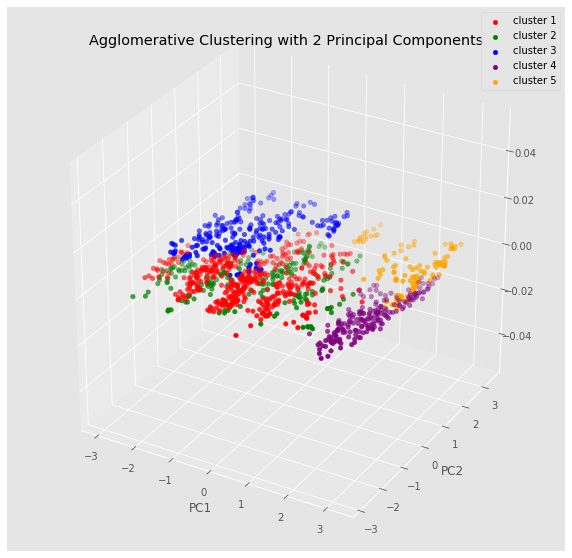

In [48]:
survey_p3 = pd.DataFrame(PCA(n_components = 3).fit_transform(survey))
preds = pd.Series(AgglomerativeClustering(n_clusters = 5,).fit_predict(survey_p3))
survey_p3 = pd.concat([survey_p3, preds], axis =1)
survey_p3.columns = [0,1,2, 'target']

fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection='3d')
colors = ['red', 'green', 'blue', 'purple', 'orange']
ax.scatter(survey_p3[survey_p3['target']==0].iloc[:,0], survey_p3[survey_p3.target==0].iloc[:,1], c = colors[0], label = 'cluster 1')
ax.scatter(survey_p3[survey_p3['target']==1].iloc[:,0], survey_p3[survey_p3.target==1].iloc[:,1], c = colors[1], label = 'cluster 2')
ax.scatter(survey_p3[survey_p3['target']==2].iloc[:,0], survey_p3[survey_p3.target==2].iloc[:,1], c = colors[2], label = 'cluster 3')
ax.scatter(survey_p3[survey_p3['target']==3].iloc[:,0], survey_p3[survey_p3.target==3].iloc[:,1], c = colors[3], label = 'cluster 4')
ax.scatter(survey_p3[survey_p3['target']==4].iloc[:,0], survey_p3[survey_p3.target==4].iloc[:,1], c = colors[4], label = 'cluster 5')
plt.legend()
plt.title('Agglomerative Clustering with 2 Principal Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

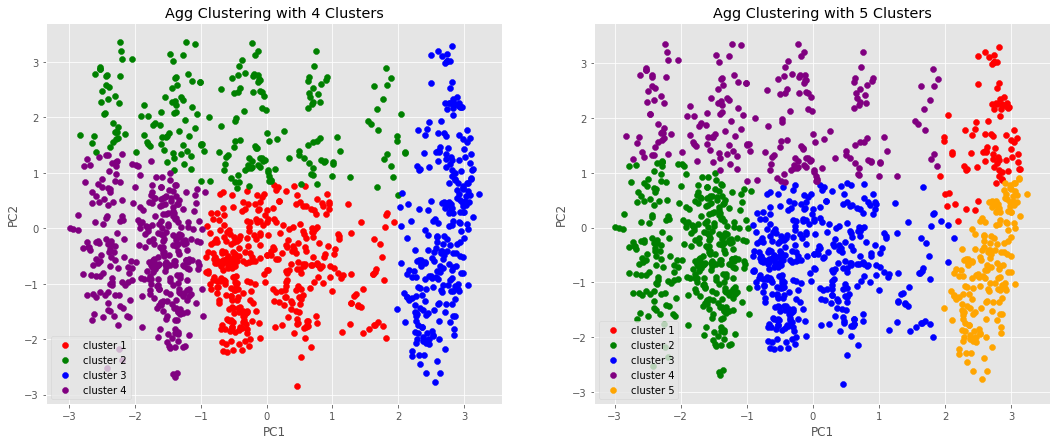

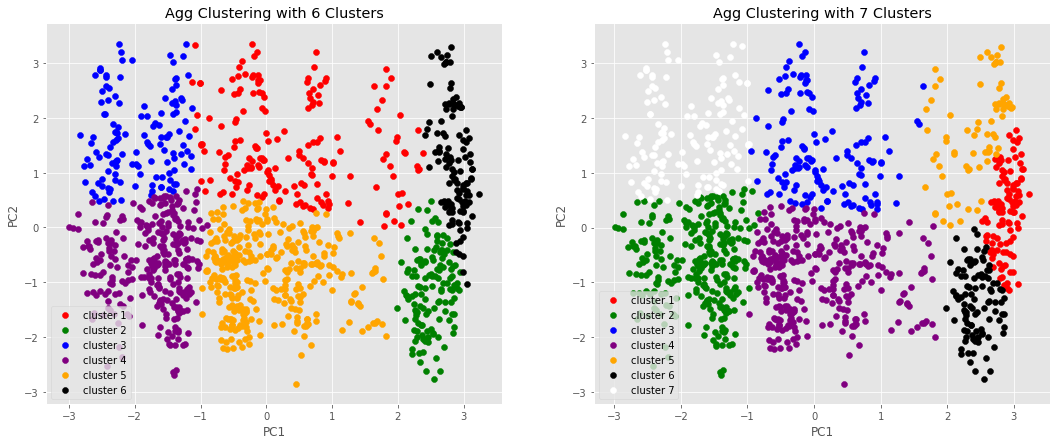

In [49]:
from sklearn.mixture import GaussianMixture

survey_p = pd.DataFrame(PCA(n_components = 2).fit_transform(survey))
preds = pd.Series(GaussianMixture(n_components = 5,).fit(survey_p).predict(survey_p))
survey_p = pd.concat([survey_p, preds], axis =1)
survey_p.columns = [0,1,'target']

fig = plt.figure(figsize = (18, 7))
colors = ['red', 'green', 'blue', 'purple', 'orange']
plt.subplot(122)
plt.scatter(survey_p[survey_p['target']==0].iloc[:,0], survey_p[survey_p.target==0].iloc[:,1], c = colors[0], label = 'cluster 1')
plt.scatter(survey_p[survey_p['target']==1].iloc[:,0], survey_p[survey_p.target==1].iloc[:,1], c = colors[1], label = 'cluster 2')
plt.scatter(survey_p[survey_p['target']==2].iloc[:,0], survey_p[survey_p.target==2].iloc[:,1], c = colors[2], label = 'cluster 3')
plt.scatter(survey_p[survey_p['target']==3].iloc[:,0], survey_p[survey_p.target==3].iloc[:,1], c = colors[3], label = 'cluster 4')
plt.scatter(survey_p[survey_p['target']==4].iloc[:,0], survey_p[survey_p.target==4].iloc[:,1], c = colors[4], label = 'cluster 5')
plt.legend()
plt.title('Agg Clustering with 5 Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')

survey_p = pd.DataFrame(PCA(n_components = 2).fit_transform(survey))
preds = pd.Series(GaussianMixture(n_components = 4,).fit(survey_p).predict(survey_p))
survey_p = pd.concat([survey_p, preds], axis =1)
survey_p.columns = [0,1,'target']

plt.subplot(121)
plt.scatter(survey_p[survey_p['target']==0].iloc[:,0], survey_p[survey_p.target==0].iloc[:,1], c = colors[0], label = 'cluster 1')
plt.scatter(survey_p[survey_p['target']==1].iloc[:,0], survey_p[survey_p.target==1].iloc[:,1], c = colors[1], label = 'cluster 2')
plt.scatter(survey_p[survey_p['target']==2].iloc[:,0], survey_p[survey_p.target==2].iloc[:,1], c = colors[2], label = 'cluster 3')
plt.scatter(survey_p[survey_p['target']==3].iloc[:,0], survey_p[survey_p.target==3].iloc[:,1], c = colors[3], label = 'cluster 4')
plt.legend()
plt.title('Agg Clustering with 4 Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')








survey_p = pd.DataFrame(PCA(n_components = 2).fit_transform(survey))
preds = pd.Series(GaussianMixture(n_components = 6,).fit(survey_p).predict(survey_p))
survey_p = pd.concat([survey_p, preds], axis =1)
survey_p.columns = [0,1,'target']

fig = plt.figure(figsize = (18, 7))
colors = ['red', 'green', 'blue', 'purple', 'orange', 'black', 'white']
plt.subplot(121)
plt.scatter(survey_p[survey_p['target']==0].iloc[:,0], survey_p[survey_p.target==0].iloc[:,1], c = colors[0], label = 'cluster 1')
plt.scatter(survey_p[survey_p['target']==1].iloc[:,0], survey_p[survey_p.target==1].iloc[:,1], c = colors[1], label = 'cluster 2')
plt.scatter(survey_p[survey_p['target']==2].iloc[:,0], survey_p[survey_p.target==2].iloc[:,1], c = colors[2], label = 'cluster 3')
plt.scatter(survey_p[survey_p['target']==3].iloc[:,0], survey_p[survey_p.target==3].iloc[:,1], c = colors[3], label = 'cluster 4')
plt.scatter(survey_p[survey_p['target']==4].iloc[:,0], survey_p[survey_p.target==4].iloc[:,1], c = colors[4], label = 'cluster 5')
plt.scatter(survey_p[survey_p['target']==5].iloc[:,0], survey_p[survey_p.target==5].iloc[:,1], c = colors[5], label = 'cluster 6')

plt.legend()
plt.title('Agg Clustering with 6 Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')

survey_p = pd.DataFrame(PCA(n_components = 2).fit_transform(survey))
preds = pd.Series(GaussianMixture(n_components = 7,).fit(survey_p).predict(survey_p))
survey_p = pd.concat([survey_p, preds], axis =1)
survey_p.columns = [0,1,'target']

plt.subplot(122)
plt.scatter(survey_p[survey_p['target']==0].iloc[:,0], survey_p[survey_p.target==0].iloc[:,1], c = colors[0], label = 'cluster 1')
plt.scatter(survey_p[survey_p['target']==1].iloc[:,0], survey_p[survey_p.target==1].iloc[:,1], c = colors[1], label = 'cluster 2')
plt.scatter(survey_p[survey_p['target']==2].iloc[:,0], survey_p[survey_p.target==2].iloc[:,1], c = colors[2], label = 'cluster 3')
plt.scatter(survey_p[survey_p['target']==3].iloc[:,0], survey_p[survey_p.target==3].iloc[:,1], c = colors[3], label = 'cluster 4')
plt.scatter(survey_p[survey_p['target']==4].iloc[:,0], survey_p[survey_p.target==4].iloc[:,1], c = colors[4], label = 'cluster 5')
plt.scatter(survey_p[survey_p['target']==5].iloc[:,0], survey_p[survey_p.target==5].iloc[:,1], c = colors[5], label = 'cluster 6')
plt.scatter(survey_p[survey_p['target']==6].iloc[:,0], survey_p[survey_p.target==6].iloc[:,1], c = colors[6], label = 'cluster 7')

plt.legend()
plt.title('Agg Clustering with 7 Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()
plt.show()


In [52]:
git remote add origin https://github.com/sun58/Ml-practive.git
git push -u origin master

SyntaxError: invalid syntax (<ipython-input-52-a1098dead6b1>, line 1)